# Auditory BSC

Imports for pylib

In [1]:
from __future__ import division
import sys
import numpy as np
import joblib
import pylab as plt
%matplotlib inline
import glob
from pulp.utils import create_output_path
from pulp.utils.parallel import pprint
from pulp.utils.barstest import generate_bars
from pulp.utils.autotable import AutoTable
import tables
from pulp.utils.parallel import stride_data

from pulp.utils.datalog import dlog, StoreToH5, TextPrinter, StoreToTxt

from pulp.em import EM
from pulp.em.annealing import LinearAnnealing

from pulp.em.camodels.bsc_et import BSC_ET

from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.preprocessing import StandardScaler

plt.rcParams['image.cmap'] = 'viridis'

#np.seterr(all='raise')

## Pre-processing the data

1. Log-Transform of Mel-Spectrogram
2. Extracting image patches
3. Compute and substract intercept
4. Normalize? Before or after extraction?

Import the Mel-Frequency spectrum (MFS) data from the Forrest Gump Audio-Movie

In [14]:
lqmfs_list = glob.glob('data/evenfinergrained/*.mfs')
feature_list = [np.genfromtxt(lqmfs_fn,delimiter=',') for lqmfs_fn in lqmfs_list]
ft_freq = feature_list[0].shape[1]

Extracts speech patches (for a small part to test) of the log of the MFS data

In [15]:
feature_list = feature_list[:3]

In [16]:
test_part = np.concatenate([features for features in feature_list])
#test_part = np.log(test_part)

scaler = StandardScaler()
test_part = scaler.fit_transform(test_part)
#test_part -= np.min(test_part)-0.001
#test_part = np.log(test_part)
patchsize = (10,48)
patches_flat = np.reshape(extract_patches_2d(test_part,patchsize),(test_part.shape[0] - patchsize[0] + 1,-1))

#patches_flat = scaler.fit_transform(patches_flat)

#patches_flat = (patches_flat-np.mean(patches_flat))/np.std(patches_flat)

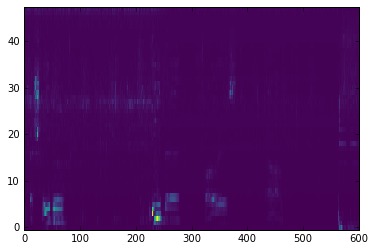

In [12]:
plt.imshow(test_part[100:700].T,origin='lower',aspect='auto',interpolation='nearest')

In [5]:
output_path = create_output_path()

N = patches_flat.shape[0]
D = patches_flat.shape[1]

H = 50

Hprime = 8
gamma = 5

model = BSC_ET(D, H, Hprime, gamma, to_learn=['W','sigma','pi','mu'])

data = {'y':patches_flat}


out_fname = output_path + "/data.h5"

In [18]:
joblib.dump({'data':patches_flat,'patchsize':patchsize},'data/preprocessed/100ms_patches_10ms_steps_zscored_half.pkl',compress=3)

['data/preprocessed/100ms_patches_10ms_steps_zscored_half.pkl',
 'data/preprocessed/100ms_patches_10ms_steps_zscored_half.pkl_01.npy.z']

In [6]:


#setting up logging/output
print_list = ('T', 'Q', 'pi', 'sigma', 'N', 'MAE', 'L')
dlog.set_handler(print_list, TextPrinter)
h5store_list = ('W', 'pi', 'sigma', 'y', 'MAE', 'N','L','Q','mu')
dlog.set_handler(h5store_list, StoreToH5, output_path +'/result.h5')

###### Initialize model #######
# Initialize (Random) model parameters
model_params = model.standard_init(data)
#model_params['mu'] = np.mean(data['y'].mean(axis=0))

#### Choose annealing schedule #####
#Linear Annealing
anneal = LinearAnnealing(150)
#Increases variance by a muliplicative factor that slowly goes down to 1
anneal['T'] = [(0., 6.), (.3, 1.)]      # [(iteration, value),... ]
#Reduces truncation rate so as not to prematurely exclude data 
anneal['Ncut_factor'] = [(0, 2.0), (.25, 1.)]     
#Simulated annealing of parameters
anneal['W_noise'] = [(0, 2.0), (.3, 0.0)]
#Include prior parameters in the annealing schedule
anneal['anneal_prior'] = False


# Create and start EM annealing
em = EM(model=model, anneal=anneal)
em.data = data
em.lparams = model_params
em.run()

dlog.close(True)
pprint("Done")

0.00511521290858
Anneal factor: 2.0
N_use: 137251
 A_pigamma 0.999521782786
         N = 137383 
         L = -193.311186683 
        pi = 0.000109980725059 
     sigma = 0.995086744995 
         T = 6.0 
0.86219415738
Anneal factor: 1.97297297297
N_use: 137383
 A_pigamma 1.0
         N = 137383 
         L = -189.923094953 
        pi = 0.000194185566386 
     sigma = 0.933256865239 
         T = 5.88888888889 
0.888932088309
Anneal factor: 1.94594594595
N_use: 137382
 A_pigamma 1.0
         N = 137383 
         L = -179.161643362 
        pi = 0.000258849433469 
     sigma = 0.912024983784 
         T = 5.77777777778 
0.890405916419
Anneal factor: 1.91891891892
N_use: 137382
 A_pigamma 1.0
         N = 137383 
         L = -175.520329312 
        pi = 0.000291891108541 
     sigma = 0.903663619572 
         T = 5.66666666667 
0.88623353294
Anneal factor: 1.89189189189
N_use: 137382
 A_pigamma 1.0
         N = 137383 
         L = -174.159218554 
        pi = 0.00033211259262 
     si

KeyboardInterrupt: 

In [7]:
import h5py
import os

with h5py.File(max(glob.glob('output/home/mboos/anaconda/lib/python2.7/site-packages/IPython/kernel/*'),key=os.path.getctime) + \
            '/result.h5','r') as results:
    L, mu, W, sigma, pi = [results[key][()] for key in ['L',
                                                       'mu',
                                                       'W',
                                                       'sigma',
                                                       'pi']]

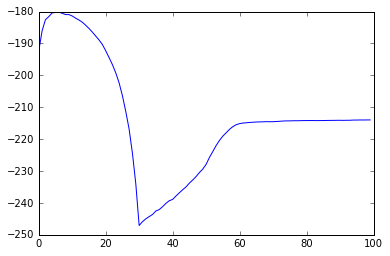

In [8]:
plt.plot(L)

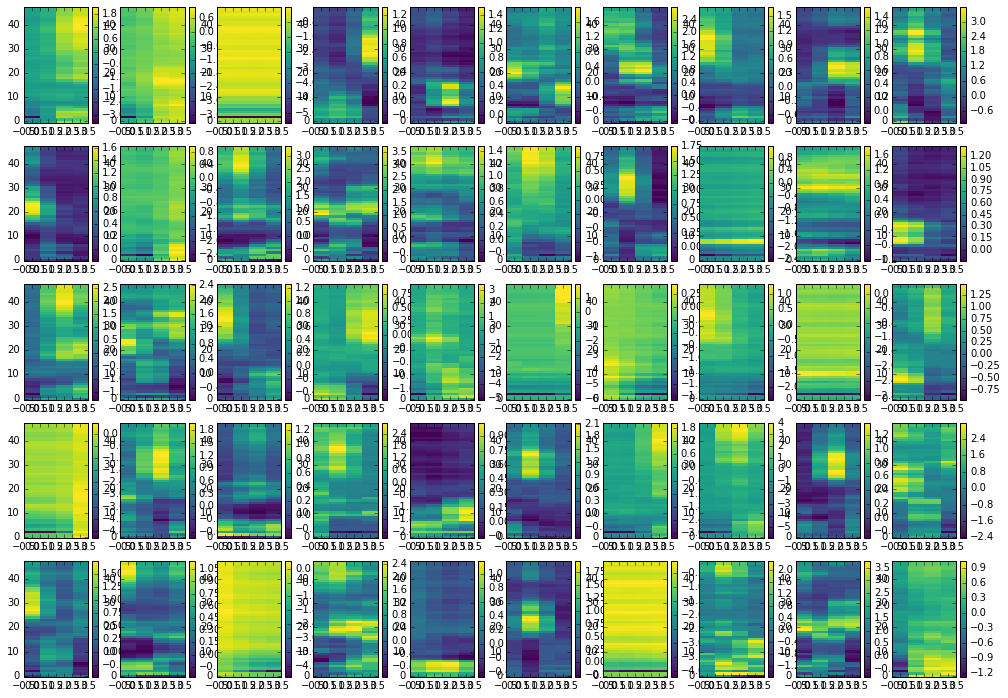

In [9]:
ts = -1
test_W = np.reshape(W[ts,:,:].T,(H,) + patchsize)
#test_W = np.swapaxes(test_W.T,1,2)
plt.figure(figsize=(17,12))
for i,comp in enumerate(test_W):
    plt.subplot(5,10,i+1)
    plt.imshow(comp.T,origin='lower',interpolation='nearest',aspect='auto',cmap='viridis')
    plt.colorbar()
   

In [11]:
sources = np.zeros((data['y'].shape[0],H))
for i in xrange(sources.shape[0]):
    sources[i,data['candidates'][i]] = 1

In [12]:
reconstructed = sources.dot(W[-1].T)

In [13]:
reconstructed_patches = np.reshape(reconstructed,(data['y'].shape[0],)+patchsize)
test_patches = np.reshape(patches_flat,(data['y'].shape[0],)+patchsize)

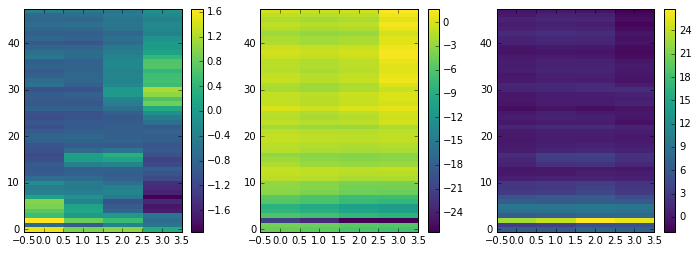

In [16]:
i = 250
imin = min(np.min(test_patches[i]),np.min(reconstructed_patches[i]))
imax = max(np.max(test_patches[i]),np.max(reconstructed_patches[i]))
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(test_patches[i].T,origin='lower',aspect='auto',interpolation='nearest')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(reconstructed_patches[i].T,origin='lower',aspect='auto',interpolation='nearest')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow((test_patches[i]-reconstructed_patches[i]).T,origin='lower',aspect='auto',interpolation='nearest')
plt.colorbar()

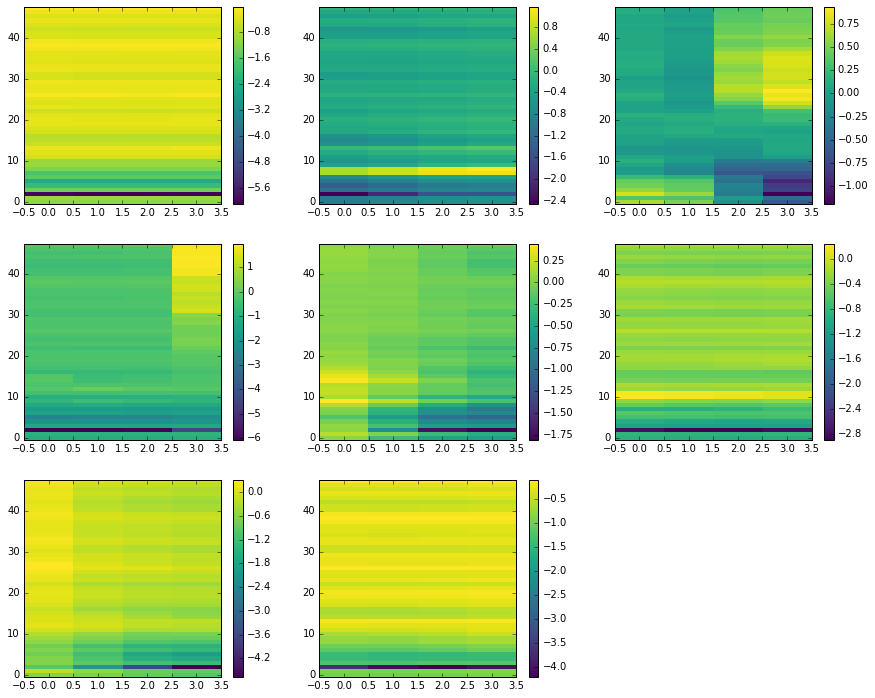

In [17]:
actual_W = W[-1][:,np.where(sources[i])[0]]
actual_W = np.reshape(actual_W.T,(-1,)+patchsize)
plt.figure(figsize=(15,12))
for j,comp in enumerate(actual_W):
    plt.subplot(3,3,j+1)
    plt.imshow(comp.T,origin='lower',interpolation='nearest',aspect='auto',cmap='viridis')
    plt.colorbar()

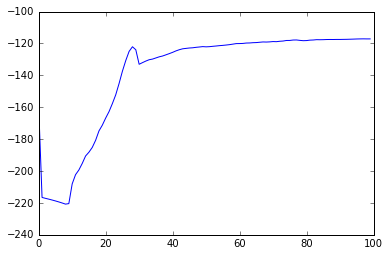

In [17]:
plt.plot(results['L'])

### Mini-Batch Dictionary Learning

Alternative, since the EM library gives numerical errors

In [20]:
from sklearn.decomposition import MiniBatchDictionaryLearning

mbdic = MiniBatchDictionaryLearning(n_components=30,verbose=True)
mbdic.fit(patches_flat)

[dict_learning] ........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

MiniBatchDictionaryLearning(alpha=1, batch_size=3, dict_init=None,
              fit_algorithm='lars', n_components=30, n_iter=1000, n_jobs=1,
              random_state=None, shuffle=True, split_sign=False,
              transform_algorithm='omp', transform_alpha=None,
              transform_n_nonzero_coefs=None, verbose=True)

### Visualize the dictionary atoms

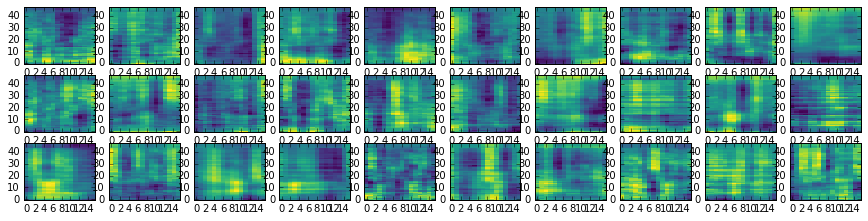

In [21]:
V = mbdic.components_
plt.figure(figsize=(15,12))
for i,comp in enumerate(V):
    plt.subplot(10,10,i+1)
    plt.imshow(comp.reshape(patchsize).T,origin='lower',interpolation='nearest',aspect='auto',cmap='viridis')
    

### Reconstruct some data with the dictionary

In [22]:
transform_algorithm = 'omp'
test_patches = np.reshape(extract_patches_2d(np.log(feature_list[1][500:1000,:]),(16,48)),(-1,16*48))
code = mbdic.transform(test_patches)
reconstructed_patches = np.dot(code, mbdic.components_)


In [23]:
test_patches = np.reshape(test_patches,(-1,16,48))
reconstructed_patches = np.reshape(reconstructed_patches,(-1,16,48))


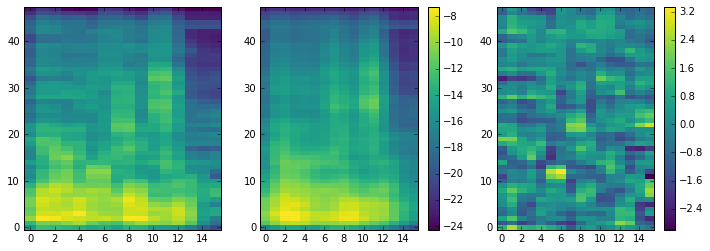

In [12]:
i = 100
imin = min(np.min(test_patches[i]),np.min(reconstructed_patches[i]))
imax = max(np.max(test_patches[i]),np.max(reconstructed_patches[i]))
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(test_patches[i].T,origin='lower',aspect='auto',interpolation='nearest',vmin=imin,vmax=imax)
plt.subplot(1,3,2)
plt.imshow(reconstructed_patches[i].T,origin='lower',aspect='auto',interpolation='nearest',vmin=imin,vmax=imax)
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow((test_patches[i]-reconstructed_patches[i]).T,origin='lower',aspect='auto',interpolation='nearest')
plt.colorbar()

In [24]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

stim_tl = reconstruct_from_patches_2d(np.exp(test_patches),(500,48))
rec_tl = reconstruct_from_patches_2d(np.exp(reconstructed_patches),(500,48))

MSE: 1.00932647627e-10


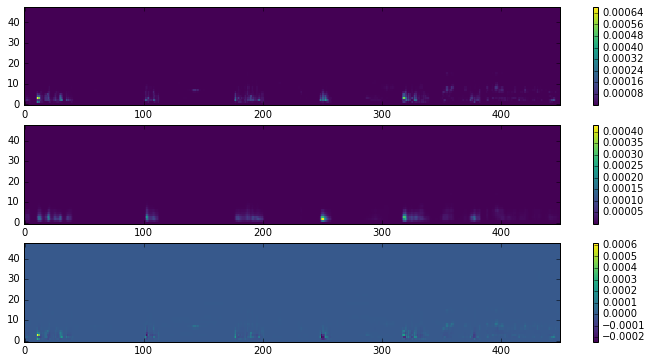

In [25]:
from sklearn.metrics import mean_squared_error

length = 450

plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.imshow(stim_tl[:length].T,origin='lower',aspect='auto',interpolation='nearest')
plt.colorbar()
plt.subplot(3,1,2)
plt.imshow(rec_tl[:length].T,origin='lower',aspect='auto',interpolation='nearest')
plt.colorbar()
plt.subplot(3,1,3)
plt.imshow((stim_tl[:length]-rec_tl[:length]).T,origin='lower',aspect='auto',interpolation='nearest')
plt.colorbar()
print('MSE: {}'.format(mean_squared_error(stim_tl[:length],rec_tl[:length])))